# Домашняя работа NLP 2

Выберите корпус отзывов на товары одной из категорий Amazon: http://jmcauley.ucsd.edu/data/amazon/
(В низу страницы по ссылке есть код для загрузки данных, можете им воспользоваться)

Допустим, что вам нужно подготовить аналитический отчет по этим отзывам — например, для производителя нового продукта этой категории. Для этого будем искать упоминания товаров в отзывах (будем считать их NE). Учтите, что упоминание может выглядеть не только как "Iphone 10", но и как "модель", "телефон" и т.п.
Важное замечание: в задании приводятся примеры решений, вы можете их использовать!

(3 балла) Предложите 3 способа найти упоминания товаров в отзывах. Например, использовать bootstrapping: составить шаблоны вида "холодильник XXX", найти все соответствующие n-граммы и выделить из них называние товара. Могут помочь заголовки и дополнительные данные с Amazon (Metadata здесь) Какие данные необходимы для каждого из способов? Какие есть достоинства/недостатки? ✅

**Ответ**

1. Кластеризовать векторные представления названий продукта из метаданных: так мы получим разные типы продуктов Проранжировать отзывы по "релевантности" к базовому названию продукта. Например, подсчитать bm25. Выделить именные паттерны из топ-10 релевантных отзывов по каждому типу продуктов


    + Кластеризация объединит galaxy watch и smart watch

    - В кластеризации обычно куча мусора, тем более, когда она на human generated content
    
    - Нет уверенности, что релевантность по поиску коррелирует с частотностью NE по отзывам. Люди часто называют вещи не своими именами

2. Объединить продукты по категории прописанной в метадате. Выбираем родовое название для категории и находим к нему самых частотных ближайших соседей. Строим по ним n-граммы и ранжируем разными методами. Аггрегируем полученные результаты, чтобы выделить n-граммы, подходящие по нескольким ранжированиям. Затем смотрим, что вышло и применяем фильтры, если нужно


    + Полнота будет супер

    + Принимаем решение на основании нескольких метрик

    - Скорее всего есть мусор

    + Он чистится data-driven фильтрами: посмотрим, что вышло в топ и отфильтруем, как нужно

    - Не объединяем galaxy watch и smart watch

   **Я решила остановиться на этом способе, только еще добавила знание про название товара**

3. Выделяем существительные из названия товаров, потом смотрим по данным на самые частотные коллокации с ними и по этому строим паттерны для yargy (вообще для чего-то такого есть библиотека TermExtract, можно извлечь с ее помощью и посмотреть самые частотные + близкие по эмбеддингам коллокации, она извлекает именно термины). TermExtract использовать не вышло, потому что она старая и есть какие-то конфликты версий библиотек


    + Самим писать ничего не надо, TermExtract все за нас сделает
    
    + Паттерны тоже приятный фильтр
    
    - Когда хорошая точность, часто плохая полнота. Есть риск потерять неожиданные коллокации

(2 балла) Реализуйте один из предложенных вами способов. Примеры в качестве подсказки (можно использовать один из них): написать правила с помощью natasha/yargy составить мини-словарь сущностей/дескрипторов, расширить с помощью эмбеддингов (например, word2vec) ✅

(1 балл) Соберите n-граммы с полученными сущностями (NE + левый сосед / NE + правый сосед) ✅

(3 балла) Ранжируйте n-граммы с помощью 3 коллокационных метрик (t-score, PMI и т.д.). Не забудьте про частотный фильтр / сглаживание. Выберите лучший результат (какая метрика ранжирует выше коллокации, подходящие для отчёта). ✅

(1 балл) Сгруппируйте полученные коллокации по NE, выведите примеры для 5 товаров. Должны получиться примерно такие группы: ✅

watch stylish watch good watches great watch love this watch ...

Бонус (2 балла): если придумаете способ объединить синонимичные упоминания (например, "Samsung Galaxy Watch", "watch", "smartwatch")

In [5]:
import json
from tqdm.auto import tqdm
import pandas as pd

In [17]:
reviews = open('Clothing_Shoes_and_Jewelry_5.json').readlines()

In [65]:
review = json.loads(reviews[27866])

In [66]:
review

{'overall': 3.0,
 'verified': True,
 'reviewTime': '06 7, 2016',
 'reviewerID': 'A3GPMIUWL9EB5M',
 'asin': 'B0000CBALZ',
 'style': {'Size:': ' 62W x 30L', 'Color:': ' Overdyed Black'},
 'reviewerName': 'Papaloop',
 'reviewText': 'Size runs small. Especially in the thigh area.',
 'summary': 'Three Stars',
 'unixReviewTime': 1465257600}

In [10]:
review_texts = [json.loads(r)['reviewText'] for r in reviews]

In [3]:
meta = open('meta_Clothing_Shoes_and_Jewelry.json').readlines()

In [4]:
meta = {json.loads(m)['asin'] : {'category' : json.loads(m)['category'], 'title' : json.loads(m)['title'] if 'title' in json.loads(m).keys() else ''} for m in meta}

In [19]:
review_data = []
for review in reviews:
    try:
        text = json.loads(review)['reviewText']
        idx = json.loads(review)['asin']
        category = meta[idx]['category']
        title = meta[idx]['title']
        review_data.append((text, idx, category, title))
    except:
        continue

Exception ignored in: <function tqdm.__del__ at 0x107b315e0>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tqdm/std.py", line 1147, in __del__
    self.close()
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tqdm/notebook.py", line 286, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm' object has no attribute 'disp'


In [18]:
len(reviews)

11285464

In [21]:
df = pd.DataFrame(review_data, columns =['review_text', 'product_idx', 'product_category', 'product_title'])

In [22]:
df.to_csv('reviews_with_meta.csv')

In [26]:
df['subcategory'] = df['product_category'].apply(lambda x: x[2] if len(x) > 2 else '')

In [34]:
df['subcategory'].unique()[:50]

array(['Jewelry', 'Clothing', 'Accessories', 'Travel Accessories',
       'Maternity', 'Imported', 'Men', 'Watches', 'Kids & Baby', 'Women',
       'Props', 'Briefcases', 'Uniforms, Work & Safety', 'Shoes',
       'Luggage', 'Messenger Bags', 'Baby Girls', 'Handbags & Wallets',
       '', 'Baby Boys', 'Shoe Care & Accessories', 'Big & Tall',
       'Travel Duffels', 'Waist Packs', 'Jewelry Accessories', 'Gym Bags',
       'Plus-Size', 'Backpacks', 'neoprene', 'chiffon',
       '80% hi-bulk acrylic / 20% stetch nylon',
       '85% Polyester, 15% Cotton', 'School Uniforms',
       'Contemporary & Designer', '100% Leather',
       'August Birthstone Necklace Perfect for Mothers & Grandmothers',
       'October Birthstone Necklace Perfect for Mothers & Grandmothers',
       'May Birthstone Necklace Perfect for Mothers & Grandmothers',
       'Dupont Supplex 3-ply nylon 7 pockets including cordura lined pliers pocket 27 bar tacks 18" outseam | 7.5" inseam light weight, strong, comfortable s

Разделим товары на мужскую и женскую обувь

In [39]:
def gender(x):
    if 'Women' in x:
        return 'fem'
    if 'Men' in x:
        return 'm'
    else:
        return ''

In [40]:
df_shoes = df.loc[df['subcategory'] == 'Shoes']

In [41]:
df_shoes['gender'] = df_shoes['product_category'].apply(lambda x: gender(x))

/var/folders/b8/zfvmm7h90xvdz7yjjhdtzxvw0000gn/T/ipykernel_62405/3249773513.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_shoes['gender'] = df_shoes['product_category'].apply(lambda x: gender(x))


In [45]:
fem_shoes = df_shoes.loc[df_shoes.gender == 'fem'][:1000000]
fem_shoes.to_csv('fem_shoes.csv')
fem_shoes

,review_text,product_idx,product_category,product_title,subcategory,gender
1475,These shoes were recommended to me by a severa...,B00004VWJ3,"[Clothing, Shoes & Jewelry, Women, Shoes, Mule...","Birki's Super Pu, Black, 44 M EU (13 Women /11...",Shoes,fem
1476,Excellent,B00004VWJ3,"[Clothing, Shoes & Jewelry, Women, Shoes, Mule...","Birki's Super Pu, Black, 44 M EU (13 Women /11...",Shoes,fem
1477,I love these shoes! I have plantar fasciitis a...,B00004VWJ3,"[Clothing, Shoes & Jewelry, Women, Shoes, Mule...","Birki's Super Pu, Black, 44 M EU (13 Women /11...",Shoes,fem
1478,"We take off our shoes in the house, but have 4...",B00004VWJ3,"[Clothing, Shoes & Jewelry, Women, Shoes, Mule...","Birki's Super Pu, Black, 44 M EU (13 Women /11...",Shoes,fem
1479,"Good, as always",B00004VWJ3,"[Clothing, Shoes & Jewelry, Women, Shoes, Mule...","Birki's Super Pu, Black, 44 M EU (13 Women /11...",Shoes,fem
...,...,...,...,...,...,...
5252152,I had forgotten that these shoes run small. I...,B00HGABX0I,"[Clothing, Shoes & Jewelry, Women, Shoes, Outd...",KEEN Women's Koven Hiking Shoe,Shoes,fem
5252153,Really nice. Fit is a little large but feel s...,B00HGADFZO,"[Clothing, Shoes & Jewelry, Women, Shoes, Outd...",KEEN Women's Durand Low Waterproof Hiking Shoe,Shoes,fem
5252154,"I bought these size 9 shoes for me, but ended ...",B00HGADFZO,"[Clothing, Shoes & Jewelry, Women, Shoes, Outd...",KEEN Women's Durand Low Waterproof Hiking Shoe,Shoes,fem
5252155,LOVE THEM. No breaking in needed. They've been...,B00HGADFZO,"[Clothing, Shoes & Jewelry, Women, Shoes, Outd...",KEEN Women's Durand Low Waterproof Hiking Shoe,Shoes,fem


In [44]:
m_shoes = df_shoes.loc[df_shoes.gender == 'm']
m_shoes.to_csv('m_shoes.csv')
m_shoes

,review_text,product_idx,product_category,product_title,subcategory,gender
1977,i love these shoes. i ware them alot. i have t...,B00006XXGO,"[Clothing, Shoes & Jewelry, Men, Shoes, Fashio...",Converse Chuck Taylor All Star Canvas Low Top ...,Shoes,m
1978,this is the best shoe I have ever bought. I lo...,B00006XXGO,"[Clothing, Shoes & Jewelry, Men, Shoes, Fashio...",Converse Chuck Taylor All Star Canvas Low Top ...,Shoes,m
1979,"Lord, could Converse have got it any more righ...",B00006XXGO,"[Clothing, Shoes & Jewelry, Men, Shoes, Fashio...",Converse Chuck Taylor All Star Canvas Low Top ...,Shoes,m
1980,"What can I say?I love this shoe,there awesome....",B00006XXGO,"[Clothing, Shoes & Jewelry, Men, Shoes, Fashio...",Converse Chuck Taylor All Star Canvas Low Top ...,Shoes,m
1981,"When basketballer Charles ""Chuck"" Taylor walke...",B00006XXGO,"[Clothing, Shoes & Jewelry, Men, Shoes, Fashio...",Converse Chuck Taylor All Star Canvas Low Top ...,Shoes,m
...,...,...,...,...,...,...
11275547,Looks okay in the picture here but material ha...,B01HJH7W0W,"[Clothing, Shoes & Jewelry, Men, Shoes, Oxfords]",Deer Stags Men's Hampden Oxford,Shoes,m
11275548,I like these shoes. After hit and miss of shoe...,B01HJH7W0W,"[Clothing, Shoes & Jewelry, Men, Shoes, Oxfords]",Deer Stags Men's Hampden Oxford,Shoes,m
11275549,"Nice, I wore these to a dress event and they l...",B01HJH7W0W,"[Clothing, Shoes & Jewelry, Men, Shoes, Oxfords]",Deer Stags Men's Hampden Oxford,Shoes,m
11275550,Love the shoes! I get compliments all the time...,B01HJH7W0W,"[Clothing, Shoes & Jewelry, Men, Shoes, Oxfords]",Deer Stags Men's Hampden Oxford,Shoes,m


# Загружаем данные

Понятно, что абсолютный путь это плохо, но данные много весят и на гитхаб не влезут, поэтому, кажется, запустить все равно не выйдет(

In [3]:
! unzip '/Users/a19336136/Downloads/Telegram Desktop/fem_shoes.csv.zip'

Archive:  /Users/a19336136/Downloads/Telegram Desktop/fem_shoes.csv.zip
  inflating: fem_shoes.csv           


In [7]:
df_fem = pd.read_csv('fem_shoes.csv')

In [8]:
df_fem[:50] 

,Unnamed: 0,review_text,product_idx,product_category,product_title,subcategory,gender
0,1475,These shoes were recommended to me by a severa...,B00004VWJ3,"['Clothing, Shoes & Jewelry', 'Women', 'Shoes'...","Birki's Super Pu, Black, 44 M EU (13 Women /11...",Shoes,fem
1,1476,Excellent,B00004VWJ3,"['Clothing, Shoes & Jewelry', 'Women', 'Shoes'...","Birki's Super Pu, Black, 44 M EU (13 Women /11...",Shoes,fem
2,1477,I love these shoes! I have plantar fasciitis a...,B00004VWJ3,"['Clothing, Shoes & Jewelry', 'Women', 'Shoes'...","Birki's Super Pu, Black, 44 M EU (13 Women /11...",Shoes,fem
3,1478,"We take off our shoes in the house, but have 4...",B00004VWJ3,"['Clothing, Shoes & Jewelry', 'Women', 'Shoes'...","Birki's Super Pu, Black, 44 M EU (13 Women /11...",Shoes,fem
4,1479,"Good, as always",B00004VWJ3,"['Clothing, Shoes & Jewelry', 'Women', 'Shoes'...","Birki's Super Pu, Black, 44 M EU (13 Women /11...",Shoes,fem
...,...,...,...,...,...,...,...
999995,5252152,I had forgotten that these shoes run small. I...,B00HGABX0I,"['Clothing, Shoes & Jewelry', 'Women', 'Shoes'...",KEEN Women's Koven Hiking Shoe,Shoes,fem
999996,5252153,Really nice. Fit is a little large but feel s...,B00HGADFZO,"['Clothing, Shoes & Jewelry', 'Women', 'Shoes'...",KEEN Women's Durand Low Waterproof Hiking Shoe,Shoes,fem
999997,5252154,"I bought these size 9 shoes for me, but ended ...",B00HGADFZO,"['Clothing, Shoes & Jewelry', 'Women', 'Shoes'...",KEEN Women's Durand Low Waterproof Hiking Shoe,Shoes,fem
999998,5252155,LOVE THEM. No breaking in needed. They've been...,B00HGADFZO,"['Clothing, Shoes & Jewelry', 'Women', 'Shoes'...",KEEN Women's Durand Low Waterproof Hiking Shoe,Shoes,fem


Давайте обучим на данных w2v и посмотрим, что похоже на слово shoes

In [24]:
import gensim
from string import punctuation
from collections import Counter

In [20]:
def process(x):
    x = x.lower().strip()
    for char in punctuation:
        x = x.replace(char, ' ')
    return x.split()

In [21]:
sent_corp = [process(i) for i in df_fem[:500000].review_text.tolist()]

In [22]:
model = gensim.models.Word2Vec(sent_corp, window=3, sg=0)

In [33]:
model.wv.most_similar('shoes', topn=15)

[('sneakers', 0.857509970664978),
 ('sandals', 0.8315462470054626),
 ('boots', 0.7668453454971313),
 ('slippers', 0.7075112462043762),
 ('flats', 0.7033877968788147),
 ('clogs', 0.7003418803215027),
 ('sandles', 0.6955327391624451),
 ('pumps', 0.6485317945480347),
 ('crocs', 0.6422736644744873),
 ('thongs', 0.6319131851196289),
 ('rainboots', 0.6299407482147217),
 ('nikes', 0.6109881401062012),
 ('flipflops', 0.5970699787139893),
 ('mules', 0.5959691405296326),
 ('loafers', 0.5838873386383057)]

In [34]:
bow = []
for i in sent_corp:
    bow += i
word_counts = Counter(bow)

In [87]:
print('shoes', word_counts['shoes'])
for i in model.wv.most_similar('shoes', topn=15):
    print(i[0], word_counts[i[0]])

shoes 198417
sneakers 8405
sandals 33914
boots 59079
slippers 17173
flats 4280
clogs 3715
sandles 869
pumps 1109
crocs 9501
thongs 649
rainboots 164
nikes 391
flipflops 479
mules 370
loafers 606


In [86]:
print('shoe', word_counts['shoe'])
for i in model.wv.most_similar('shoe', topn=15):
    print(i[0], word_counts[i[0]])

shoe 112744
sandal 13395
boot 23273
sneaker 3575
slipper 5285
clog 1783
sandle 377
pump 800
product 12256
loafer 534
item 2863
model 2386
shoes 198417
style 25888
mule 245
design 5633


Запомним самые частотные. Так как в дальнейшем нас просят проанализировать названия по 5 продуктам, выберем 5 помимо shoes: shoes, boots, slippers, sandals, crocs, sneakers

In [206]:
SHOE_NAMES = ['shoe', 'boot', 'slipper', 'sandal', 'crocs', 'sneaker']

In [62]:
vecs = [model.wv['shoes']]
words = ['shoes']
for i in model.wv.most_similar('shoes', topn=15):
    vecs.append(model.wv[i[0]])
    words.append(i[0])

In [67]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

In [59]:
tsne = TSNE(n_components=2, init='pca', random_state=42, verbose=2)
reduced = tsne.fit_transform(vecs)

[t-SNE] Computing 15 nearest neighbors...
[t-SNE] Indexed 16 samples in 0.000s...
[t-SNE] Computed neighbors for 16 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 16 / 16
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] Computed conditional probabilities in 0.004s
[t-SNE] Iteration 50: error = 86.5245514, gradient norm = 0.3819191 (50 iterations in 0.010s)
[t-SNE] Iteration 100: error = 43.8006210, gradient norm = 0.0259324 (50 iterations in 0.009s)
[t-SNE] Iteration 150: error = 43.7193222, gradient norm = 0.0185806 (50 iterations in 0.009s)
[t-SNE] Iteration 200: error = 53.7985420, gradient norm = 0.0146592 (50 iterations in 0.008s)
[t-SNE] Iteration 250: error = 72.9067841, gradient norm = 0.0420057 (50 iterations in 0.008s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.906784
[t-SNE] Iteration 300: error = 0.8698807, gradient norm = 0.0009660 (50 iterations in 0.009s)
[t-SNE] Iteration 350: error = 0.6600602, gradient norm = 

In [65]:
inds = range(16)
x_coords = [coords[0] for coords in reduced[inds]]
y_coords = [coords[1] for coords in reduced[inds]]

Я думала, что можно будет как-то красиво объеднить слова в группы, например, сказать что flats и slippers скорее одно и то же, но не получлось

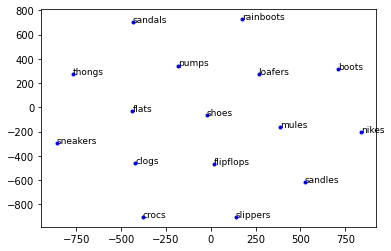

In [68]:
for (x, y, word) in zip(x_coords, y_coords, words):
    plt.scatter(x, y, marker='.', color='blue')
    plt.text(x+0.01, y+0.01, word, fontsize=9)
plt.show()

Посмотрим, называют ли обувь словами из заголовка продукта

In [83]:
intersections = []
for title, text in zip(df_fem.product_title.tolist()[:500000], sent_corp):
    title_set = set(process(str(title)))
    text_set = set(text)
    inter = text_set.intersection(title_set)
    if inter:
        intersections.append(' '.join(list(inter)))

In [84]:
count_inters = Counter(intersections)
count_inters.most_common(100)

[('s', 17079),
 ('boot', 5728),
 ('flip', 4795),
 ('shoe', 4260),
 ('converse', 4159),
 ('toms', 4052),
 ('shoes', 3762),
 ('on', 3744),
 ('crocs', 3394),
 ('sandal', 3308),
 ('and', 2396),
 ('keds', 2283),
 ('teva', 2179),
 ('all', 1924),
 ('flop flip', 1454),
 ('boots', 1441),
 ('skechers', 1286),
 ('vans', 1281),
 ('birkenstock', 1211),
 ('slipper', 1175),
 ('flip flops', 1092),
 ('boot s', 1089),
 ('sandals', 1082),
 ('keen', 1080),
 ('women s', 898),
 ('for', 880),
 ('on toms', 865),
 ('converse all', 809),
 ('clarks', 792),
 ('slippers', 747),
 ('teva s', 729),
 ('ugg', 726),
 ('on slip', 716),
 ('minnetonka', 710),
 ('hiking', 708),
 ('flip teva', 667),
 ('the', 660),
 ('chuck', 658),
 ('on s', 643),
 ('sneaker', 611),
 ('walking', 599),
 ('shoes toms', 588),
 ('spirit easy', 587),
 ('leather', 580),
 ('jambu', 579),
 ('frye', 578),
 ('flat', 566),
 ('shoe s', 556),
 ('women', 511),
 ('rain', 498),
 ('running', 485),
 ('bass', 484),
 ('water', 484),
 ('reef', 476),
 ('sandal s',

Что мы отсюда видим? Что в ботинках могут появляться:

1. Бренды
2. Размеры
3. Цель (running, walking, hiking)

Давайте сразу выберем бренды

In [203]:
brands = [i[0] for i in count_inters.most_common(100) if len(i[0]) > 3]

In [184]:
def process_upper(x):
    x = x.strip()
    for char in punctuation:
        x = x.replace(char, ' ')
    return x.split()

In [186]:
up_corp = [process_upper(i) for i in df_fem[:500000].review_text.tolist()] 

In [190]:
intersections_up = []
for title, text in zip(df_fem.product_title.tolist()[:500000], up_corp):
    title_set = set(process_upper(str(title)))
    text_set = set(text)
    inter = text_set.intersection(title_set)
    if inter:
        intersections_up.append(' '.join(list(inter)))

In [194]:
count_inters_up = Counter(intersections_up)
count_inters_up.most_common(100)

[('s', 28029),
 ('and', 3962),
 ('Teva', 2836),
 ('Converse', 2255),
 ('for', 2247),
 ('Keds', 2213),
 ('Crocs', 2089),
 ('Birkenstock', 1471),
 ('on', 1442),
 ('TOMS', 1295),
 ('Skechers', 1270),
 ('Teva s', 964),
 ('Minnetonka', 849),
 ('Reef', 805),
 ('Vans', 735),
 ('New Balance', 726),
 ('Propet', 601),
 ('Jambu', 592),
 ('Chuck', 581),
 ('Bass', 572),
 ('Easy Spirit', 568),
 ('Saucony', 567),
 ('Merrell', 553),
 ('Clarks', 492),
 ('Dansko', 452),
 ('Aerosoles', 444),
 ('UGG', 398),
 ('on s', 381),
 ('Daniel Green', 379),
 ('Nine West', 376),
 ('Alegria', 361),
 ('and s', 359),
 ('I', 328),
 ('8', 316),
 ('Reef for', 305),
 ('Sanuk', 298),
 ('Dr Martens', 287),
 ('with and', 283),
 ('Taylor Chuck', 280),
 ('All', 270),
 ('Keds s', 265),
 ('Naturalizer', 263),
 ('Ariat', 253),
 ('Crocs and', 253),
 ('Minnetonka s', 244),
 ('in', 225),
 ('with', 221),
 ('Merrell s', 220),
 ('Crocs s', 218),
 ('The', 217),
 ('Sperry', 215),
 ('Capezio', 212),
 ('for and', 212),
 ('Trotters', 201),
 (

Можно выбрать бренды из списка выше, а можно, например, сделать фильтр по частотности через список, который мы считали для текста в нижнем регистре

In [201]:
brands_up = [i[0].lower() for i in count_inters_up.most_common(100) if len(i[0]) > 3]

In [204]:
brands_final = list(set(brands).intersection(set(brands_up)))
brands_final

['ecco',
 'teva s',
 'easy',
 'crocs s',
 'birkenstock',
 'nine west',
 'dr martens',
 'nike',
 'clarks',
 'keds s',
 'reef',
 'new balance',
 'ariat',
 'chuck',
 'sanuk',
 'crocs and',
 'propet',
 'merrell',
 'alegria',
 'with',
 'teva',
 'flip',
 'converse',
 'boot',
 'toms',
 'on s',
 'bass',
 'aerosoles',
 'jambu',
 'dansko',
 'keds',
 'fitflop',
 'skechers',
 'women s',
 'shoe',
 'vans',
 'crocs',
 'shoes',
 'saucony',
 'naturalizer',
 'bearpaw',
 'minnetonka',
 'toms s']

Тут меньше брендов и больше мусора, зато мы понимаем, что тут бренды самые значимые

# Соберем n-граммы

In [128]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.util import ngrams
from nltk.collocations import *
import tqdm
tqdm.notebook.tqdm().pandas()


lemmatizer = WordNetLemmatizer()

0it [00:00, ?it/s]

In [105]:
df_fem = df_fem[:500000]

In [110]:
def full_process(x):

    x = x.lower().strip()
    tokens = word_tokenize(x)
    clean_text = ''
    for i in tokens:
        if i.isalpha():
            clean_text = clean_text + ' ' + lemmatizer.lemmatize(i)
    return clean_text

In [111]:
df_fem['clean_review'] = df_fem['review_text'].progress_apply(lambda x: full_process(x))

  0%|          | 0/500000 [00:00<?, ?it/s]

In [112]:
df_fem.to_csv('fem_shoes.csv')

In [207]:
SHOE_NAMES

['shoe', 'boot', 'slipper', 'sandal', 'crocs', 'sneaker']

### Биграммы

In [118]:
n = 2
bigrams = ngrams(' '.join(df_fem['clean_review']).split(), n)

In [119]:
bi = Counter(bigrams)

In [121]:
shoe_bigrams = {shoe : [] for shoe in SHOE_NAMES}
for bigram in bi.most_common():
    for shoe in shoe_bigrams.keys():
        if shoe in bigram[0]:
            shoe_bigrams[shoe].append(bigram)

In [133]:
df_bigrams = pd.DataFrame({i : [' '.join(j[0]) for j in shoe_bigrams[i][:150]] for i in SHOE_NAMES})

In [134]:
df_bigrams

,shoe,boot,slipper,sandal,crocs,sneaker
0,these shoe,these boot,these slipper,these sandal,of crocs,these sneaker
1,the shoe,the boot,slipper i,sandal i,crocs i,sneaker i
2,shoe i,boot i,the slipper,the sandal,these crocs,sneaker and
3,shoe are,boot are,slipper are,sandal are,crocs are,the sneaker
4,this shoe,boot and,a slipper,sandal and,the crocs,sneaker are
...,...,...,...,...,...,...
145,style shoe,boot well,have slipper,pretty sandal,hope crocs,sneaker style
146,flat shoe,boot no,slipper did,water sandal,tried crocs,sneaker comfy
147,shoe super,boot there,awesome slipper,right sandal,crocs after,up sneaker
148,wonderful shoe,wonderful boot,slipper seem,stylish sandal,any crocs,sneaker ha


### Триграммы

In [129]:
n = 3
trigrams = ngrams(' '.join(df_fem['clean_review']).split(), n)
tri = Counter(trigrams)

In [130]:
shoe_trigrams = {shoe : [] for shoe in SHOE_NAMES}
for trigram in tri.most_common():
    for shoe in shoe_trigrams.keys():
        if shoe in trigram[0]:
            shoe_trigrams[shoe].append(trigram)

In [135]:
df_trigrams = pd.DataFrame({i : [' '.join(j[0]) for j in shoe_trigrams[i][:150]] for i in SHOE_NAMES})

In [136]:
df_trigrams

,shoe,boot,slipper,sandal,crocs,sneaker
0,love these shoe,love these boot,love these slipper,love these sandal,pair of crocs,love these sneaker
1,these shoe are,these boot are,these slipper are,these sandal are,i love crocs,pair of sneaker
2,of the shoe,of the boot,slipper they are,sandal i have,crocs i have,these sneaker are
3,these shoe i,these boot i,slipper i have,these sandal i,these crocs are,sneaker i have
4,shoe i have,boot they are,pair of slipper,sandal they are,of crocs i,sneaker they are
...,...,...,...,...,...,...
145,normal shoe size,wearing these boot,the slipper wa,ordered these sandal,crocs are comfortable,sneaker but the
146,recommend this shoe,the boot so,slipper i ordered,sandal so much,crocs do not,with the sneaker
147,shoe fit a,boot were a,these slipper my,this sandal and,other crocs that,sneaker are perfect
148,walking shoe i,this boot and,slipper is very,sandal they were,that the crocs,sneaker that is


Давайте теперь посмотрим на лучшие n-граммы по метрикам коллокаций

## Ранжирование по коллокационным метрикам

Я решила использовать PMI, likelihood ratio и jaccard score. Для выделения биграмм я сделала фильтр частотности 10. Еще я сделала отдельный столбец с подсчетом частотности. В итоге я решила, что интереснее не выбирать лучшую метрику, а взять их агрегацию (получить пересечение слов из рейтингов по всем метрикам). Оно в итоге и выводится в final_bigrams и final_trigrams

In [141]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(' '.join(df_fem['clean_review']).split())
finder.apply_freq_filter(10)

In [147]:
for shoe in tqdm.tqdm(SHOE_NAMES):
    lem = lemmatizer.lemmatize(shoe)
    rate = [i for i in finder.nbest(bigram_measures.pmi, 100000000000) if lem in i][:150]
    df_bigrams[f'{lem}_pmi'] = [' '.join(i) for i in rate]

100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.63it/s]


In [149]:
for shoe in tqdm.tqdm(SHOE_NAMES):
    lem = lemmatizer.lemmatize(shoe)
    rate = [i for i in finder.nbest(bigram_measures.likelihood_ratio, 100000000000) if lem in i][:150]
    df_bigrams[f'{lem}_likelihood'] = [' '.join(i) for i in rate]

100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.12it/s]


In [151]:
for shoe in tqdm.tqdm(SHOE_NAMES):
    lem = lemmatizer.lemmatize(shoe)
    rate = [i for i in finder.nbest(bigram_measures.jaccard, 100000000000) if lem in i][:150]
    df_bigrams[f'{lem}_jaccard'] = [' '.join(i) for i in rate]

100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.71it/s]


In [156]:
final_bigrams = {}
columns = ['{}', '{}_jaccard', '{}_pmi', '{}_likelihood']
for shoe in tqdm.tqdm(SHOE_NAMES):
    lem = lemmatizer.lemmatize(shoe)
    bigram_set = set(df_bigrams[columns[0].format(lem)].tolist())
    for col in columns[1:]:
        bigram_set = set(df_bigrams[col.format(lem)].tolist()).intersection(bigram_set)
    final_bigrams[lem] = bigram_set

100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 2984.92it/s]


In [152]:
df_bigrams

,shoe,boot,slipper,sandal,crocs,sneaker,shoe_pmi,boot_pmi,slipper_pmi,sandal_pmi,...,slipper_likelihood,sandal_likelihood,crocs_likelihood,sneaker_likelihood,shoe_jaccard,boot_jaccard,slipper_jaccard,sandal_jaccard,crocs_jaccard,sneaker_jaccard
0,these shoe,these boot,these slipper,these sandal,of crocs,these sneaker,shoe horn,cowboy boot,dg slipper,lucena sandal,...,these slipper,these sandal,of crocs,these sneaker,these shoe,these boot,house slipper,these sandal,other crocs,dance sneaker
1,the shoe,the boot,slipper i,sandal i,crocs i,sneaker i,tennis shoe,tactical boot,bedroom slipper,ibiza sandal,...,house slipper,teva sandal,these crocs,sneaker i,the shoe,boot are,these slipper,teva sandal,original crocs,fashion sneaker
2,shoe i,boot i,the slipper,the sandal,these crocs,sneaker and,atheletic shoe,combat boot,greene slipper,sharon sandal,...,slipper are,this sandal,other crocs,dance sneaker,this shoe,this boot,green slipper,this sandal,regular crocs,converse sneaker
3,shoe are,boot are,slipper are,sandal are,crocs are,the sneaker,thise shoe,lexis boot,dearfoam slipper,sunbeat sandal,...,bedroom slipper,sandal i,crocs are,fashion sneaker,shoe are,the boot,bedroom slipper,keen sandal,traditional crocs,keds sneaker
4,this shoe,boot and,a slipper,sandal and,the crocs,sneaker are,shoe stretcher,paddock boot,howser slipper,yucatan sandal,...,green slipper,sandal are,love crocs,sneaker but,shoe i,rain boot,ballet slipper,favorite sandal,bistro crocs,classic sneaker
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,style shoe,boot well,have slipper,pretty sandal,hope crocs,sneaker style,leisure shoe,boot arrived,slipper person,same sandal,...,slipper although,particular sandal,size crocs,sneaker ordered,shoe bought,stylish boot,slipper super,sandal without,crocs keep,stylish sneaker
146,flat shoe,boot no,slipper did,water sandal,tried crocs,sneaker comfy,grandma shoe,boot are,slipper stay,sandal that,...,slipper too,sandal get,out crocs,sneaker when,shoe lace,boot good,slipper soft,sandal arrived,crocs these,sneaker until
147,shoe super,boot there,awesome slipper,right sandal,crocs after,up sneaker,avia shoe,fantastic boot,slipper over,sturdy sandal,...,no slipper,athens sandal,thought crocs,sneaker these,style shoe,western boot,slipper now,mush sandal,if crocs,sneaker yet
148,wonderful shoe,wonderful boot,slipper seem,stylish sandal,any crocs,sneaker ha,witch shoe,best boot,most slipper,nice sandal,...,soft slipper,sandal more,crocs at,fun sneaker,shoe there,boot super,slipper not,sandal my,crocs never,sneaker arrived


In [159]:
final_bigrams   

{'shoe': {'athletic shoe',
  'clark shoe',
  'dance shoe',
  'favorite shoe',
  'finding shoe',
  'left shoe',
  'running shoe',
  'shoe itself',
  'street shoe',
  'tennis shoe',
  'these shoe'},
 'boot': {'ariat boot',
  'awesome boot',
  'bearpaw boot',
  'beautiful boot',
  'best boot',
  'boot are',
  'boot arrived',
  'boot cut',
  'boot itself',
  'boot shaft',
  'combat boot',
  'cowboy boot',
  'emu boot',
  'favorite boot',
  'frye boot',
  'gorgeous boot',
  'hiking boot',
  'left boot',
  'muck boot',
  'rain boot',
  'riding boot',
  'rubber boot',
  'snow boot',
  'tall boot',
  'these boot',
  'this boot',
  'timberland boot',
  'ugg boot',
  'waterproof boot',
  'winter boot'},
 'slipper': {'acorn slipper',
  'awesome slipper',
  'ballerina slipper',
  'ballet slipper',
  'beautiful slipper',
  'bedroom slipper',
  'best slipper',
  'bootie slipper',
  'comfortable slipper',
  'comfy slipper',
  'cozy slipper',
  'dormie slipper',
  'favorite slipper',
  'friend slipper

Вообще, если просмотреть бираммы, то видно, что самые осмысленные NE имеют формат X shoe_name. Давайте такие и выведем как финальный результат

In [212]:
for shoe in final_bigrams.keys():
    print('Для продукта', shoe + ':')
    for i in final_bigrams[shoe]:
        if i.split()[1] == shoe and len(i.split()[0]) >3:
            print(i)
    print()

Для продукта shoe:
finding shoe
tennis shoe
running shoe
these shoe
athletic shoe
left shoe
street shoe
clark shoe
dance shoe
favorite shoe

Для продукта boot:
muck boot
beautiful boot
rain boot
awesome boot
combat boot
frye boot
gorgeous boot
this boot
ariat boot
left boot
winter boot
hiking boot
snow boot
tall boot
timberland boot
riding boot
rubber boot
best boot
favorite boot
these boot
bearpaw boot
waterproof boot
cowboy boot

Для продукта slipper:
great slipper
quality slipper
acorn slipper
house slipper
beautiful slipper
sheepskin slipper
ballet slipper
shearling slipper
awesome slipper
isotoner slipper
soft slipper
cozy slipper
only slipper
friend slipper
favorite slipper
same slipper
comfortable slipper
comfy slipper
wool slipper
these slipper
regular slipper
summer slipper
green slipper
other slipper
like slipper
bootie slipper
their slipper
bedroom slipper
left slipper
wonderful slipper
indoor slipper
warm slipper
ballerina slipper
nice slipper
wearing slipper
haflinger slip

# Лучшие триграммы

In [160]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder = TrigramCollocationFinder.from_words(' '.join(df_fem['clean_review']).split())
finder.apply_freq_filter(10)

In [162]:
for shoe in tqdm.tqdm(SHOE_NAMES):
    lem = lemmatizer.lemmatize(shoe)
    rate = [i for i in finder.nbest(trigram_measures.pmi, 100000000000) if lem in i][:150]
    df_trigrams[f'{lem}_pmi'] = [' '.join(i) for i in rate]

100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  1.88s/it]


In [163]:
for shoe in tqdm.tqdm(SHOE_NAMES):
    lem = lemmatizer.lemmatize(shoe)
    rate = [i for i in finder.nbest(trigram_measures.likelihood_ratio, 100000000000) if lem in i][:150]
    df_trigrams[f'{lem}_likelihood'] = [' '.join(i) for i in rate]

100%|█████████████████████████████████████████████| 6/6 [01:28<00:00, 14.73s/it]


In [164]:
for shoe in tqdm.tqdm(SHOE_NAMES):
    lem = lemmatizer.lemmatize(shoe)
    rate = [i for i in finder.nbest(trigram_measures.jaccard, 100000000000) if lem in i][:150]
    df_trigrams[f'{lem}_jaccard'] = [' '.join(i) for i in rate]

100%|█████████████████████████████████████████████| 6/6 [00:10<00:00,  1.70s/it]


In [176]:
final_trigrams = {}
columns = ['{}_jaccard', '{}_pmi', '{}_likelihood']  # Уберем тут просто частотность, чтобы получить побольше вариантов
for shoe in tqdm.tqdm(SHOE_NAMES):
    lem = lemmatizer.lemmatize(shoe)
    trigram_set = set(df_trigrams[columns[0].format(lem)].tolist())
    for col in columns[1:]:
        trigram_set = set(df_trigrams[col.format(lem)].tolist()).intersection(trigram_set)
    final_trigrams[lem] = trigram_set

100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 7084.97it/s]


In [177]:
df_trigrams

,shoe,boot,slipper,sandal,crocs,sneaker,shoe_pmi,boot_pmi,slipper_pmi,sandal_pmi,...,slipper_likelihood,sandal_likelihood,crocs_likelihood,sneaker_likelihood,shoe_jaccard,boot_jaccard,slipper_jaccard,sandal_jaccard,crocs_jaccard,sneaker_jaccard
0,love these shoe,love these boot,love these slipper,love these sandal,pair of crocs,love these sneaker,josef seibel shoe,harley davidson boot,daniel greene slipper,jack rogers sandal,...,slipper they are,they are sandal,crocs they are,they are sneaker,love these shoe,love these boot,daniel green slipper,love these sandal,pair of crocs,new balance sneaker
1,these shoe are,these boot are,these slipper are,these sandal are,i love crocs,pair of sneaker,enzo angiolini shoe,miz mooz boot,isotoner ballerina slipper,sanuk ibiza sandal,...,they are slipper,sandal they are,they are crocs,sneaker they are,these shoe are,these boot are,love these slipper,most comfortable sandal,crocs flip flop,easy spirit sneaker
2,of the shoe,of the boot,slipper they are,sandal i have,crocs i have,these sneaker are,ro hommerson shoe,justin gypsy boot,satin ballerina slipper,pedic walker sandal,...,slipper my foot,sandal my foot,crocs flip flop,sneaker my foot,of the shoe,pair of boot,these slipper are,these sandal are,batali bistro crocs,love these sneaker
3,these shoe i,these boot i,slipper i have,these sandal i,these crocs are,sneaker i have,bella vita shoe,la canadienne boot,daniel green slipper,dawgs z sandal,...,slipper i have,flip flop sandal,flip flop crocs,sneaker i have,pair of shoe,of the boot,best slipper ever,pair of sandal,been wearing crocs,pair of sneaker
4,shoe i have,boot they are,pair of slipper,sandal they are,of crocs i,sneaker they are,lindsay phillips shoe,timberland lexis boot,bear paw slipper,ecco yucatan sandal,...,i have slipper,sandal flip flop,crocs i have,pair of sneaker,most comfortable shoe,boot they are,like wearing slipper,best sandal ever,love these crocs,most comfortable sneaker
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,normal shoe size,wearing these boot,the slipper wa,ordered these sandal,crocs are comfortable,sneaker but the,shoe kept slipping,frye boot which,comfortable house slipper,love birkenstock sandal,...,good quality slipper,to find sandal,i know crocs,sneaker is not,like this shoe,favorite boot ever,slipper very soft,teva sandal before,crocs are comfortable,these sneaker good
146,recommend this shoe,the boot so,slipper i ordered,sandal so much,crocs do not,with the sneaker,non slip shoe,new hiking boot,the slipper itself,sandal that provides,...,slipper good quality,these sandal is,my other crocs,sneaker since i,these shoe the,into the boot,slipper have been,this sandal for,have had crocs,purchased these sneaker
147,shoe fit a,boot were a,these slipper my,this sandal and,other crocs that,sneaker are perfect,shoe arrived yesterday,of sorel boot,almost like slipper,sandal all summer,...,these slipper my,these sandal not,style of crocs,all the sneaker,them these shoe,received these boot,slipper were too,like this sandal,and these crocs,about these sneaker
148,walking shoe i,this boot and,slipper is very,sandal they were,that the crocs,sneaker that is,athletic type shoe,love bearpaw boot,ugg slipper and,comfortable sandal ever,...,are great slipper,it these sandal,crocs i also,sneaker all the,got these shoe,for these boot,the only slipper,open toed sandal,crocs i had,sneaker and they


In [178]:
final_trigrams

{'shoe': set(),
 'boot': set(),
 'slipper': {'better than slipper',
  'feel like slipper',
  'kind of slipper',
  'love these slipper',
  'most comfortable slipper',
  'my favorite slipper',
  'pair of slipper',
  'purchased these slipper',
  'recommend these slipper',
  'slipper all day',
  'slipper even though',
  'slipper fit perfectly',
  'slipper for year',
  'slipper highly recommend',
  'slipper run small',
  'slipper well made',
  'slipper year ago',
  'the best slipper',
  'these slipper are',
  'well made slipper'},
 'sandal': {'flip flop sandal',
  'most comfortable sandal',
  'my favorite sandal',
  'sandal year ago'},
 'crocs': {'any other crocs',
  'been wearing crocs',
  'better than crocs',
  'bought these crocs',
  'crocs are great',
  'crocs are perfect',
  'crocs at all',
  'crocs because of',
  'crocs because they',
  'crocs can be',
  'crocs do not',
  'crocs fit perfectly',
  'crocs flip flop',
  'crocs for work',
  'crocs for year',
  'crocs have been',
  'crocs 

В целом, триграммы вышли не особо осознанными. Полезными могут быть только **flip flop crocs**, **new balance sneaker**, **chuck taylor sneaker** и конструкции **type of X**, **pair of X**

Вообще я хотела сделать то же самое для мужских ботинок, чтобы сравнить и показать работодателю полную аналитику, но не успела. Будем считать, что мы продаем только женскую обувь